# 프로젝트 : SRGAN 활용하기

## 프로젝트 1 : 직접 고른 이미지로 SRGAN 실험하기


## 프로젝트 1-1. 높은 해상도 사진

### 1. (적당히) 높은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds 
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras import Input, Model
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.python.keras import applications
from skimage import data
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from PIL import Image
from glob import glob
import warnings
warnings.filterwarnings("ignore")

In [2]:
hr_image = Image.open('/home/aiffel/aiffel/super_resolution/cat.jpeg')

In [3]:
hr_image = np.array(hr_image)

In [4]:
hr_image.shape

(168, 300, 3)

Text(0.5, 1.0, 'HR')

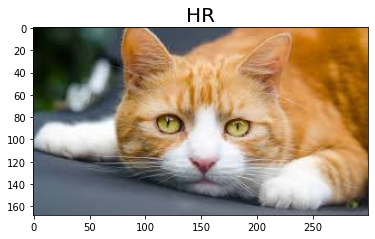

In [5]:
plt.figure(figsize=(6,4))
plt.imshow(hr_image)
plt.title('HR', fontsize=20)

### 2. 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 1/4로 줄입니다.  cv2.resize()를 사용해 봅시다.

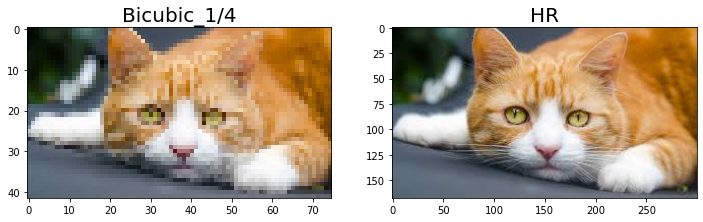

In [6]:
bicubic_image = cv2.resize(
    hr_image, 
    dsize=(75, 42), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

lr_image = bicubic_image
images = [lr_image, hr_image]

titles = ["Bicubic_1/4", "HR"]

plt.figure(figsize=(12,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)    

### 3. 줄인 저해상도 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [7]:
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [8]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

train, valid = tfds.load(
    "div2k/bicubic_x4", 
    split=["train","validation"],
    as_supervised=True
)

In [9]:
srgan_hr = apply_srgan(lr_image)

In [10]:
srgan_hr.shape

(168, 300, 3)

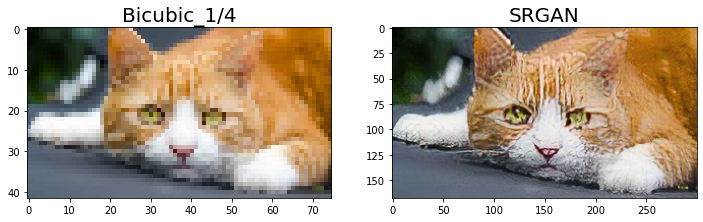

In [11]:
images = [lr_image, srgan_hr]

titles = ["Bicubic_1/4", "SRGAN"]

plt.figure(figsize=(12,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)    

### 4. 2.의 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 마찬가지로 cv2.resize()를 사용해 봅시다.

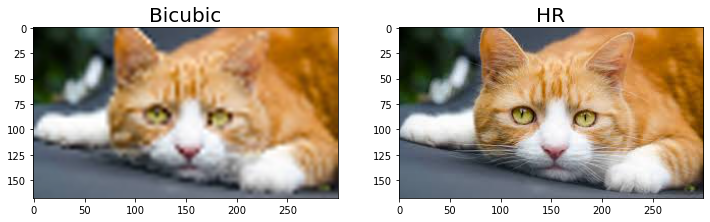

In [12]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(300, 168), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

hlr_image = bicubic_image
images = [hlr_image, hr_image]
titles = ["Bicubic", "HR"]

plt.figure(figsize=(12,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

### 5. 3개 이미지(4.의 Bicubic의 결과, 3.의 SRGAN의 결과, 1.의 원래 고해상도 이미지)를 나란히 시각화 합니다. 
각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

In [13]:
# 이미지의 특정 부분을 잘라내는 함수를 정의합니다.
def crop(image, left_top, x=50, y=50):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

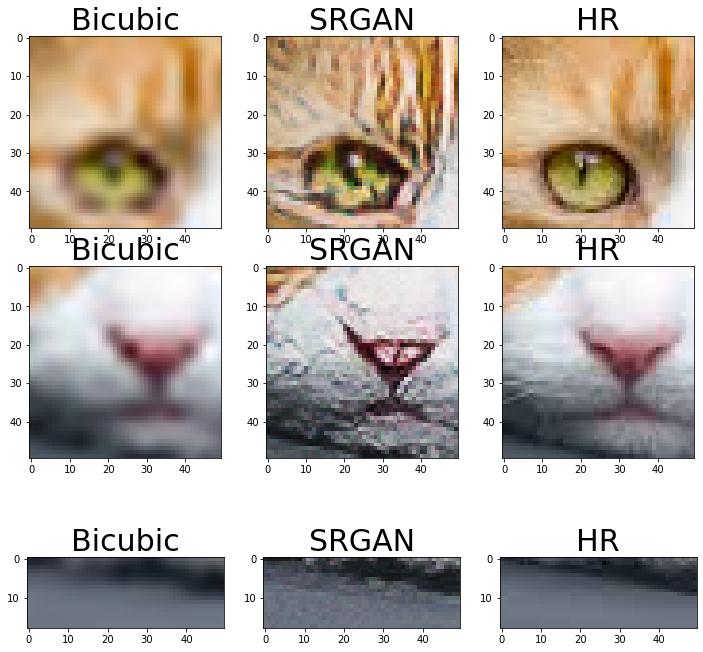

In [14]:
# 자세히 시각화 하기 위해 3개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 3개 입니다.
left_tops = [(50,100), (100,120), (150,150)]

images = []
for left_top in left_tops:
    img1 = crop(hlr_image, left_top)
    img2 = crop(srgan_hr , left_top)
    img3 = crop(hr_image, left_top)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

# print(images)
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)


### 6. 선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 어떠한 결과가 나왔으며, 왜 이러한 결과가 출력되었는지 설명해 봅시다. (정답은 없습니다)

- SRGAN은 Bicubic 보다 고양이를 좀 더 잘 표현했지만, 그 자체로 놓고 보았을 때 약간의 왜곡과 함꼐 표현이 거친 것을 볼 수 있습니다.
- Generator은 Discriminator을 속이기 위해 데이터 분포만 모방을 하는 과정에서 현실에는 없는 이미지를 진짜처럼 보이기 위한 과정에서 왜곡을 나타낼 수 있다고 봅니다.
- 그래서 정답에 가까워지기 위해선 비슷한 카테고리 내의 객체의 특징에 대해 많이 학습을 하여 현실적으로 우리가 생각하는 것과 비슷하게 이미지 생성을 할 수 있게 하여야 한다고 봅니다.

## 프로젝트 1-2. 낮은 해상도 사진

### 1. (적당히) 낮은 해상도를 가진 이미지를 검색해서 한 장 고른 후 저장하고 불러옵니다.

In [22]:
lr_image = Image.open('/home/aiffel/aiffel/super_resolution/cat1.jpg')

In [23]:
lr_image = np.array(lr_image)

In [24]:
lr_image.shape

(202, 288, 3)

Text(0.5, 1.0, 'LR')

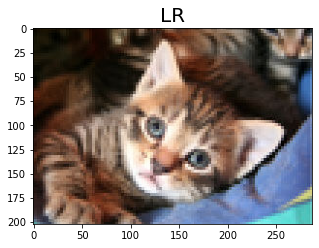

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(lr_image)
plt.title('LR', fontsize=20)

### 2. 불러온 이미지를 입력으로 SRGAN을 이용해 고해상도 이미지를 생성합니다. 이전에 사용한 apply_srgan 함수를 사용하면 쉽습니다.

In [26]:
srgan_hr = apply_srgan(lr_image)

In [27]:
srgan_hr.shape

(808, 1152, 3)

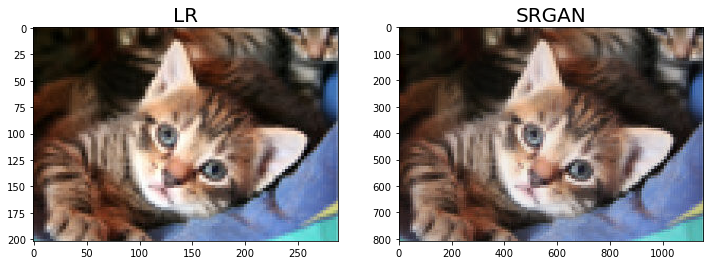

In [28]:
images = [lr_image, srgan_hr]

titles = ["LR", "SRGAN"]

plt.figure(figsize=(12,8))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)    

### 3. 1.에서 불러온 이미지에 bicubic interpolation을 적용해 가로 및 세로 픽셀 수를 다시 4배로 늘립니다. 
cv2.resize()를 사용해 봅시다.


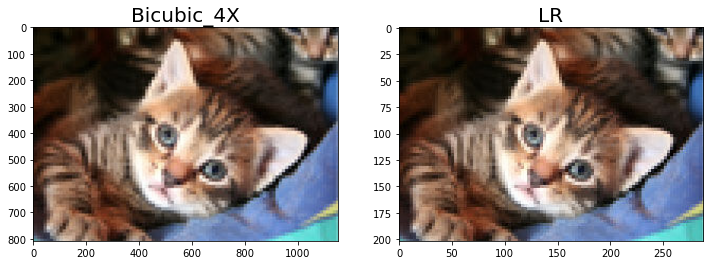

In [36]:
bicubic_image = cv2.resize(
    lr_image, 
    dsize=(1152, 808), # (가로 픽셀 수, 세로 픽셀 수)
    interpolation=cv2.INTER_CUBIC # bicubic interpolation 적용
)

hlr_image = bicubic_image
images = [hlr_image, lr_image]
titles = ["Bicubic_4X", "LR"]

plt.figure(figsize=(12,12))
for i, (image, title) in enumerate(zip(images, titles)):
    plt.subplot(1,2,i+1)
    plt.imshow(image)
    plt.title(title, fontsize=20)

### 4. 2개 이미지(3.의 Bicubic의 결과, 2.의 SRGAN의 결과)를 나란히 시각화 합니다. 
각 이미지의 제목에 어떤 방법에 대한 결과인지 표시해 주세요. 이전 시각화에 사용했던 코드를 참고하면 어렵지 않습니다.

In [37]:
# 특정 영역을 잘라낼 함수를 정의합니다.
def crop(image, left_top, x=50, y=50):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

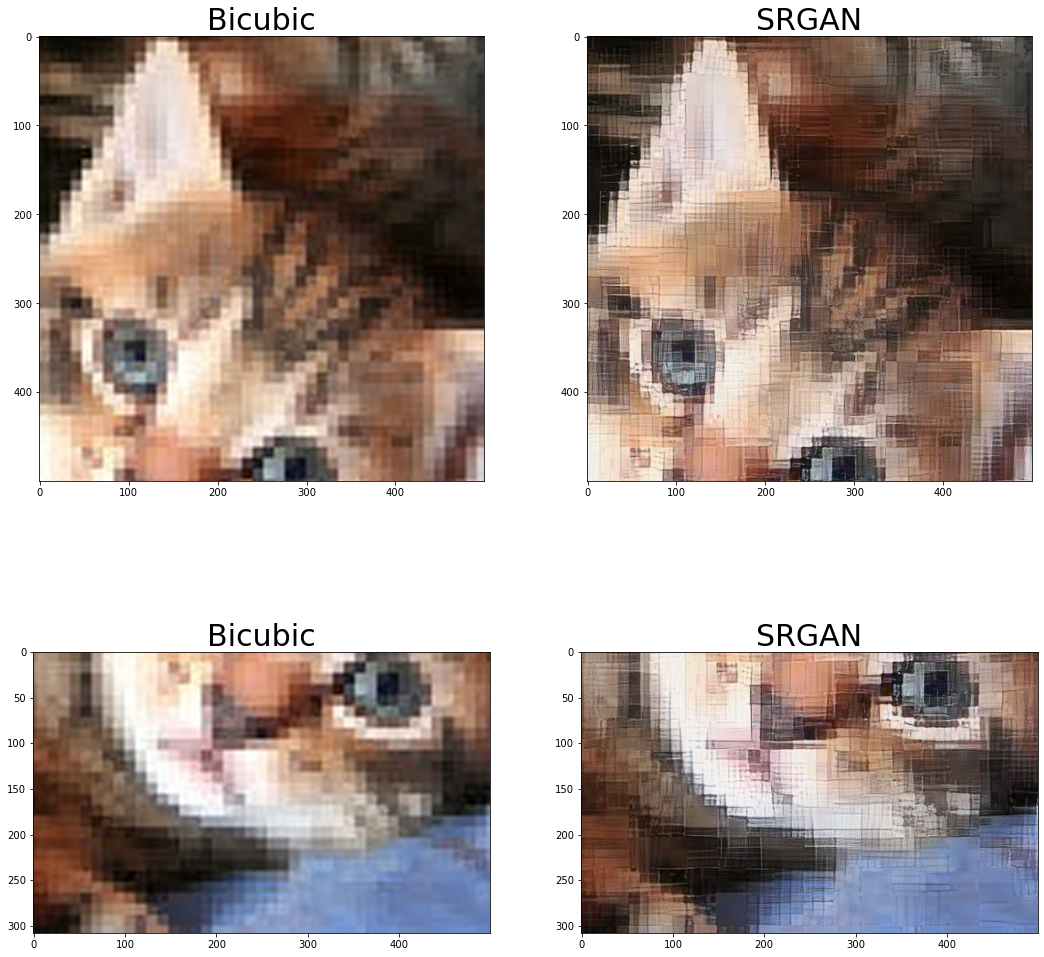

In [38]:
# 자세히 시각화 하기 위해 2개 영역을 잘라냅니다.
# 아래는 잘라낸 부분의 좌상단 좌표 2개 입니다.
left_tops = [(50,400), (500,300)]

images = []
for left_top in left_tops:
    img1 = crop(hlr_image, left_top, 500, 500)
    img2 = crop(srgan_hr , left_top, 500, 500)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 2

plt.figure(figsize=(18,18))
for i in range(4): # (image, title) in enumerate(zip(images, titles)):
    plt.subplot(2,2,i+1)
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

### 5. 왜 이러한 결과가 출력되었는지 설명해 봅시다.
선택한 이미지를 DIV2K 데이터셋에서 학습된 모델로 Super Resolution했을 때 나온 결과에 대해서 해석해 봅시다. 

- SRGAM은 비교적 또렷하게 사진이 표현되지만  Bicubic 만큼의 부드러움을 보이지 않습니다. 오히려 눈 쪽에 왜곡이 생긴 듯하다. 이유는 위에서 설명한 것과 같습니다.

# 프로젝트 2 : SRGAN을 이용해 고해상도 gif 생성하기

이번에는 이미 학습된 SRGAN을 이용해 저해상도 영상을 고해상도 영상으로 바꿔보는 프로젝트를 수행 해봅시다.

실제로 동영상의 Super Resolution은 시간 순서에 따른 다수의 프레임 정보를 고려하는 것이 더 좋지만, 처음부터 학습시키기에 많은 시간이 소요됩니다. 여기서는 이전에 사용했던 SRGAN을 이용해 한 프레임씩 고해상도 이미지로 변환시켜 모든 프레임에 대해 적용하고, 그 프레임들을 합쳐 동영상으로 만들어 봅시다.

각 프레임들을 모아 gif 파일을 만드는데 아래 라이브러리의 설치가 필요합니다.

- $ pip install imageio

## 1. gif 파일 불러오기
아래 주소에 몇 개의 gif 파일이 있습니다. 이 중 하나를 골라 다운 로드하여 아래 과정을 수행합시다. (한 개 이상의 gif 파일에 대해 아래 과정을 수행해야 합니다!)

GIF files https://drive.google.com/drive/folders/1OLsa4btdwNUiVJcOJgZe_C6-lwEoNr4e

다운받은 gif 파일을 아래와 같은 과정을 통해 각 프레임(이미지)을 불러올 수 있습니다. frames이란 리스트 안에 각각의 프레임이 들어 있습니다.

In [64]:
import cv2

# GIF 2개를 동시에 진행합니다. 
# 첫번째 GIF를 불러옵니다. 

directory='/home/aiffel/aiffel/super_resolution'
gif1 = cv2.VideoCapture(directory+'/city_night_lr.gif')
isTrue = True
frames1 = []
while isTrue:
    isTrue, frame = gif1.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames1.append(frame)

print("첫번째 GIF city_night")
print("첫번째 GIF frame 수 :", len(frames1))
print("첫번째 GIF frame 크기 :", (frames1[0].shape))

첫번째 GIF WINE
첫번째 GIF frame 수 : 8
첫번째 GIF frame 크기 : (255, 500, 3)


In [65]:
# 두번째 GIF를 불러옵니다. 
gif2 = cv2.VideoCapture(directory+ "/book_lr.gif")

isTrue = True
frames2 = []
while isTrue:
    isTrue, frame = gif2.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames2.append(frame)

print("두번째 GIF BOOK")        
print("두번째 GIF frame 수 :", len(frames2))
print("두번째 GIF frame 크기 :", (frames2[0].shape))

두번째 GIF BOOK
두번째 GIF frame 수 : 22
두번째 GIF frame 크기 : (215, 380, 3)


## 2. 프레임 별 Super Resolution 진행하기
Bicubic interpolation과 SRGAN을 이용해 각각의 가로, 세로 픽셀 수를 4배로 늘려봅시다. Super Resolution이 완료된 각각의 결과를 frames_sr이라는 리스트에 넣어주세요.

In [66]:
# Bicubic interpolation을 이용해서 가로 세로 픽셀 수를 4배로 늘리기

def hr_bicubic(frames):
    hr_bc_frames = []
    for i in range(0,len(frames)):
        bc_hr = cv2.resize(frames[i],dsize=(0,0), fx=4.0,fy=4.0,
                            interpolation=cv2.INTER_CUBIC)
        hr_bc_frames.append(bc_hr)
    return hr_bc_frames

In [67]:
# 첫번째 GIF를 Bicubic을 이용해서 가로 세로 픽셀수를 4배로 늘리기
frames1_bc_4x = hr_bicubic(frames1)

In [68]:
print("첫번째 GIF city_night")        
print("첫번째 GIF frame 수 :", len(frames1_bc_4x))
print("첫번째 GIF frame 크기 :", (frames1_bc_4x[0].shape))

첫번째 GIF WINE
첫번째 GIF frame 수 : 8
첫번째 GIF frame 크기 : (1020, 2000, 3)


In [69]:
# 두번째 GIF를 Bicubic을 이용해서 가로 세로bicubic 픽셀수를 4배로 늘리기
frames2_bc_4x = hr_bicubic(frames2)

In [70]:
print("두번째 GIF BOOK")        
print("두번째 GIF frame 수 :", len(frames2_bc_4x))
print("두번째 GIF frame 크기 :", (frames2_bc_4x[0].shape))

두번째 GIF BOOK
두번째 GIF frame 수 : 22
두번째 GIF frame 크기 : (860, 1520, 3)


In [71]:
# SRGAN을 이용해서 가로 세로 픽셀 수를 4배로 늘리기
def hr_srgan(frames):
    srgan_frames = []
    for i in range(0, len(frames)-5): #사이즈 이슈로 frame 5개 제거
        frame = apply_srgan(frames[i])
        srgan_frames.append(frame)
    return srgan_frames

In [72]:
# 첫번째 GIF를 SRGAN을 이용해서 고화질로 복원하기
frames1_sr = hr_srgan(frames1)

In [73]:
print("첫번째 GIF city_night ")       
print("첫번째 GIF frame 수 :", len(frames1_sr))
print("첫번째 GIF frame 크기 :", (frames1_sr[0].shape))

첫번째 GIF WINE 
첫번째 GIF frame 수 : 3
첫번째 GIF frame 크기 : (1020, 2000, 3)


In [74]:
# 두번째 GIF를 SRGAN을 이용해서 고화질로 복원하기
frames2_sr = hr_srgan(frames2)

In [75]:
print("두번째 CITY NIGHT ")       
print("두번째 GIF frame 수 :", len(frames2_sr))
print("두번째 GIF frame 크기 :", (frames2_sr[0].shape))

두번째 CITY NIGHT 
두번째 GIF frame 수 : 17
두번째 GIF frame 크기 : (860, 1520, 3)


## 3. 프레임을 합쳐 gif 만들기
위에서 frame_sr을 만들었다면 아래 코드와 같이 gif 파일을 생성할 수 있습니다. Bicubic 및 SRGAN의 결과를 각각 저장하여 2개 파일을 만들어 주세요.

In [76]:
import imageio

# 첫번째 GIF를 Bicubic 및 SRGAN의 결과 gif 파일로 생성하기

imageio.mimsave(directory+"/city_night_bicubic.gif", frames1_bc_4x)
imageio.mimsave(directory +"/city_night_srgan.gif", frames1_sr)

In [77]:
# 두번째 GIF를 Bicubic 및 SRGAN의 결과 gif 파일로 생성하기

imageio.mimsave(directory+"/book_bicubic.gif", frames2_bc_4x)
imageio.mimsave(directory+"/book_srgan.gif", frames2_sr)

## 4. Jupyter notebook에 gif 표시하기
아래와 같이 다운받은 저해상도 gif 파일과 고해상도 gif 파일을 각각 jupyter 내에 출력하여 최종 제출해 주시면 됩니다. jupyter 내에 출력이 어려운 경우, GitHub에 저해상도, 고해상도 gif파일을 업로드 후 링크를 첨부해주시기바랍니다. Super Resolution이 잘 적용되었는지 시각적으로 확인하기 위해 아래의 width 옵션을 적당히 크게 해주세요. 저해상도 및 고해상도 시각화의 width 값은 같도록 설정해주세요.



City Night GIF
- city_night_bicubic.gif :https://github.com/Jenny-Jo/aiffel1/blob/master/city_night_bicubic.gif
- city_night_srgan.gif : https://github.com/Jenny-Jo/aiffel1/blob/master/city_night_srgan.gif


BOOK GIF
- book_bicubic.gif : https://github.com/Jenny-Jo/aiffel1/blob/master/book_bicubic.gif
- book_SRGAN.gif: https://github.com/Jenny-Jo/aiffel1/blob/master/book_srgan.gif


- 첫번째 city_night.gif중  srgan 모델은 는 시계탑 부분이나 지나다니는 차 등의 표현이 세밀하게 되었다. 그러나 색감이 많이 죽어 bicubic이 더 화려하고 원본 자체의 색을 잘 구현하였다고 볼 수 있다.

- 두번째 book.gif 중 bicubic 모델은 프레임이 훼손되었는지 하얀 화면이 깜박이면서 나타나 품질이 좋지 않은 것을 볼 수 있다. 또한 나무결의 표현이나 책장의 표현 등이  srgan이 더 선명하게 표현된 것을 볼 수 있다. 하지만 역시나 책의 표면에 인쇄된 글씨가 잘 표현되지 않았으며 색감도 약간 누런색에서 하얗게 변한 것을 볼 수 있다.(깃헙 업로딩 문제 때문에 책 gif 파일은 뺐다.링크 참조)